# Analyze Glacier Changes by Watershed
This notebook provides an example of how to plot glacier changes (i.e., glacier mass, glacier area, and fixed glacier runoff) for various Shared Socioeconomic Pathways (SSPs) by watershed. These datasets used in this notebook can be downloaded from https://nsidc.org/data/hma2_ggp/versions/1 or you can create your own by running PyGEM and post-processing the script that aggregates individual glacier runs to regional data consistent with NSIDC standards.

## Input data
Specify the following to specify the regions, SSPs, and variables you want to process. <b>Remember to specify the filepath to where your regional files are! You also need a watershed file!</b>

In [1]:
print('\n\nCODE THIS!\n\n')



CODE THIS!




In [1]:
regions = [11]
scenarios = ['ssp126', 'ssp245', 'ssp370', 'ssp585']
vns = ['mass_annual', 'area_annual', 'runoff_fixed_monthly']
# vns = ['runoff_fixed_monthly']
agg_fp = '/Users/drounce/Documents/HiMAT/Output/simulations_aggregated/'
normyear = 2000

## Import Packages

In [2]:
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.ndimage import uniform_filter
import xarray as xr

## Dictionaries to support processing

In [3]:
ds_vn_dict = {'mass_annual':'glac_mass_annual',
              'area_annual':'glac_area_annual',
              'runoff_fixed_monthly':'glac_runoff_fixed_monthly'}
scenario_colordict = {'ssp119':'#081d58', 
                      'ssp126':'#1d91c0', 
                      'ssp245':'#7fcdbb', 
                      'ssp370':'#F47A20', 
                      'ssp585':'#ED2024'}
rgi_reg_dict = {'all':'Global',
                'global':'Global',
                1:'Alaska',
                2:'W Canada & US',
                3:'Arctic Canada North',
                4:'Arctic Canada South',
                5:'Greenland Periphery',
                6:'Iceland',
                7:'Svalbard',
                8:'Scandinavia',
                9:'Russian Arctic',
                10:'North Asia',
                11:'Central Europe',
                12:'Caucasus & Middle East',
                13:'Central Asia',
                14:'South Asia West',
                15:'South Asia East',
                16:'Low Latitudes',
                17:'Southern Andes',
                18:'New Zealand',
                19:'Antarctic & Subantarctic'
                }
scenario_namedict = {'rcp26':'RCP2.6',
                     'rcp45':'RCP4.5',
                     'rcp85':'RCP8.5',
                     'ssp119':'SSP1-1.9',
                     'ssp126':'SSP1-2.6',
                     'ssp245':'SSP2-4.5',
                     'ssp370':'SSP3-7.0',
                     'ssp585':'SSP5-8.5'}

## Plot multi-gcm median regional data for scenarios

mass_annual
area_annual
runoff_fixed_monthly


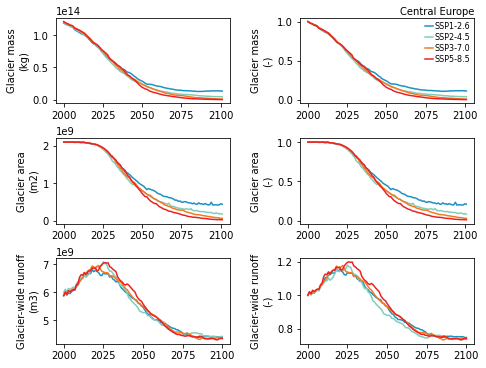

In [4]:
for region in regions:
    fig, ax = plt.subplots(len(vns), 2, squeeze=False, sharex=False, sharey=False, 
                       gridspec_kw = {'wspace':0.4, 'hspace':0.4})
    
    for nvn, vn in enumerate(vns):
        print(vn)
        # Filepath
        ds_fp = agg_fp + '/' + vn + '/' + str(region) + '/'
        # Dataset variable name
        ds_vn = ds_vn_dict[vn]
        
        for nscenario, scenario in enumerate(scenarios):
            # Filenames (lists enable batches which are used for runoff)
            ds_fns = []
            ds_fns_int = []
            for i in os.listdir(ds_fp):
                if str(region) in i and vn in i and scenario in i:
                    ds_fns.append(i)
                    if 'Batch' in i:
                        ds_fns_int.append(int(i.split('-')[-2]))
            
            # Sort filenames
            if len(ds_fns_int) > 0:
                ds_fns = [x for _,x in sorted(zip(ds_fns_int, ds_fns))]
                    
            # Load data (aggregate if necessary)
            for nfn, ds_fn in enumerate(ds_fns):
                if nfn == 0:
                    ds = xr.open_dataset(ds_fp + ds_fn)
                else:
                    ds_batch = xr.open_dataset(ds_fp + ds_fn)
                    ds = xr.concat((ds, ds_batch), dim='glacier')
            
            # Aggregate data
            if 'annual' in ds_vn:
                ds_med = ds.sum(dim='glacier').median(dim='model')
                ds_std = ds.sum(dim='glacier').std(dim='model')
                time_values = ds.year.values
            elif 'monthly' in ds_vn:
                ds_med = ds.resample(time='Y').sum('time').sum('glacier').median('model')
                ds_std = ds.resample(time='Y').sum('time').sum('glacier').std('model')
                time_values = np.array([int(x) for x in pd.DatetimeIndex(ds_med.time.values).year])
                
            # Plot data
            normyear_idx = np.where(time_values == normyear)[0][0]
            ds_med_values = ds_med[ds_vn].values
            # Smooth runoff with 11-year running mean
            if 'runoff' in ds_vn:
                ds_med_values = uniform_filter(ds_med_values, size=(11))
                
            if nvn == 0:
                label = scenario_namedict[scenario]
            else:
                label = None
            
            ax[nvn, 0].plot(time_values, ds_med_values,
                            color=scenario_colordict[scenario])
            ax[nvn, 1].plot(time_values, ds_med_values/ds_med_values[normyear_idx], 
                            color=scenario_colordict[scenario], label=label)
            
            # Add Labels
            try:
                ylabel_wunits = ds[ds_vn].long_name + '\n(' + ds[ds_vn].units + ')'
            except:
                ylabel_wunits = ds[ds_vn].long_name + '\n(' + ds[ds_vn].unit + ')'
            ylabel_norm = ds[ds_vn].long_name + '\n(-)'
            ax[nvn,0].set_ylabel(ylabel_wunits, size=10)
            ax[nvn,1].set_ylabel(ylabel_norm, size=10)

        # Legend
        if nvn == 0:
            ax[nvn,1].text(1, 1.01, rgi_reg_dict[region], size=10, horizontalalignment='right', 
                           verticalalignment='bottom', transform=ax[nvn,1].transAxes)
            ax[nvn,1].legend(loc='upper right', fontsize=8, ncol=1, columnspacing=0.5, labelspacing=0.25, 
                             handlelength=1, handletextpad=0.25, borderpad=0, frameon=False)
                
    fig.set_size_inches(2.5*len(vns),6)
    plt.show()

## Considerations
- You can save this file by replacing plt.show() with fig.savefig()
- Some of the regional runoff files can get quite large. If this crashes your notebook, you can sum each batch of glaciers prior to concatenating the datasets to save space!